In [15]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [17]:
data = 'content/drive/MyDrive/mango-disease-classification-knn/data_path'
print(data)


content/drive/MyDrive/mango-disease-classification-knn/data_path


In [2]:
import os
import time
import shutil
import pathlib
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [5]:
def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    labels = []
    for class_label in os.listdir(folder):
        class_path = os.path.join(folder, class_label)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, target_size)
                images.append(img)
                labels.append(class_label)
    return np.array(images), np.array(labels)
data_path="/content/drive/MyDrive/mango-disease-classification-knn/data_path/"

x,y=load_and_resize_images_from_folder(data_path)

split

In [6]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
x_train,x_valid,y_train,y_valid=train_test_split(x_train,y_train,test_size=0.2,random_state=42)

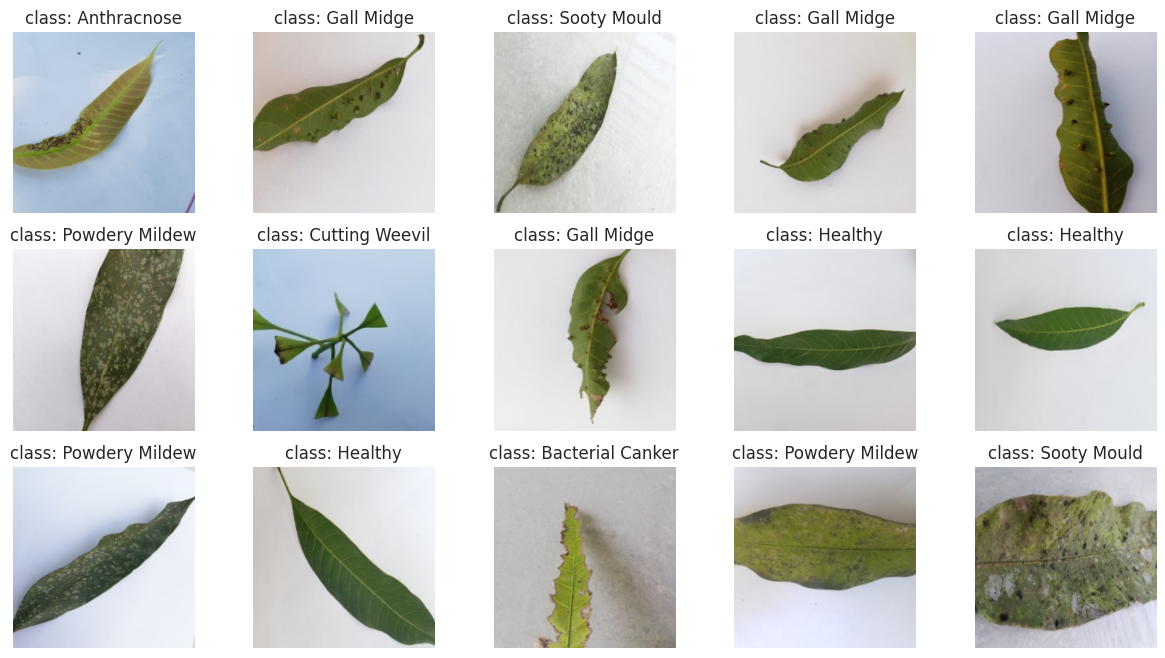

In [7]:
import random

random_indices = random.sample(range(len(x_train)), 15)


plt.figure(figsize=(15, 8))
for i, index in enumerate(random_indices, 1):
    plt.subplot(3,5, i)
    plt.imshow(x_train[index])
    plt.title(f'class: {y_train[index]}')
    plt.axis('off')

plt.show()

load pre trained vgg-16 as base model

In [8]:
base_model = tf.keras.applications.VGG16(
                                          include_top= False,
                                          weights= "imagenet",
                                          input_shape= (224,224,3),

)

58889256/58889256 [==============================] - 0s 0us/step


In [9]:
base_model.trainable = False

extract & optimizer l1 l2

In [10]:
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'linear')

])

extract to array

In [11]:
x_train_features = model.predict(x_train)
x_validation_features = model.predict(x_valid)
x_test_features = model.predict(x_test)

26/26 [==============================] - 463s 18s/step


classification

In [12]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_numeric = label_encoder.fit_transform(y_train)
y_test_numeric = label_encoder.fit_transform(y_test)
y_valid_numeric = label_encoder.fit_transform(y_valid)
y_train_hot = to_categorical(y_train_numeric, 8)
y_test_hot=to_categorical(y_test_numeric, 8)
y_valid_hot=to_categorical(y_valid_numeric, 8)

knn

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix


knn_classifier = KNeighborsClassifier(n_neighbors=3)

x_train_flatten = x_train.reshape(x_train.shape[0], -1)
x_test_flatten = x_test.reshape(x_test.shape[0], -1)

knn_classifier.fit(x_train_flatten, y_train_hot)

y_pred = knn_classifier.predict(x_test_flatten)

accuracy = accuracy_score(y_test_hot, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.6129837702871411


figuring data

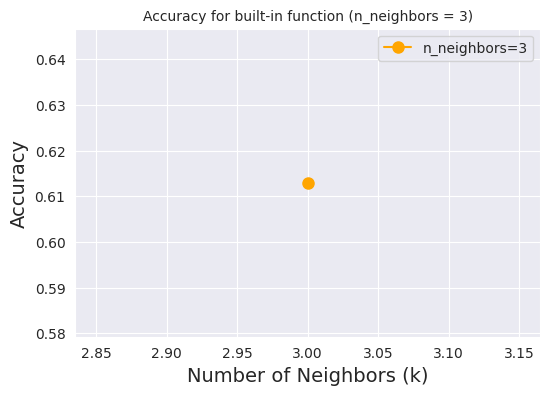



Accuracy for K=3 : 0.6129837702871411


In [15]:
plt.figure(figsize=(6, 4))
plt.plot([3], [accuracy], marker='o', color='orange', label='n_neighbors=3', markersize=8)
plt.title('Accuracy for built-in function (n_neighbors = 3)', fontsize=10)
plt.xlabel('Number of Neighbors (k)', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

print("\n")
print(f'Accuracy for K=3 : {accuracy}')

confusion matrix

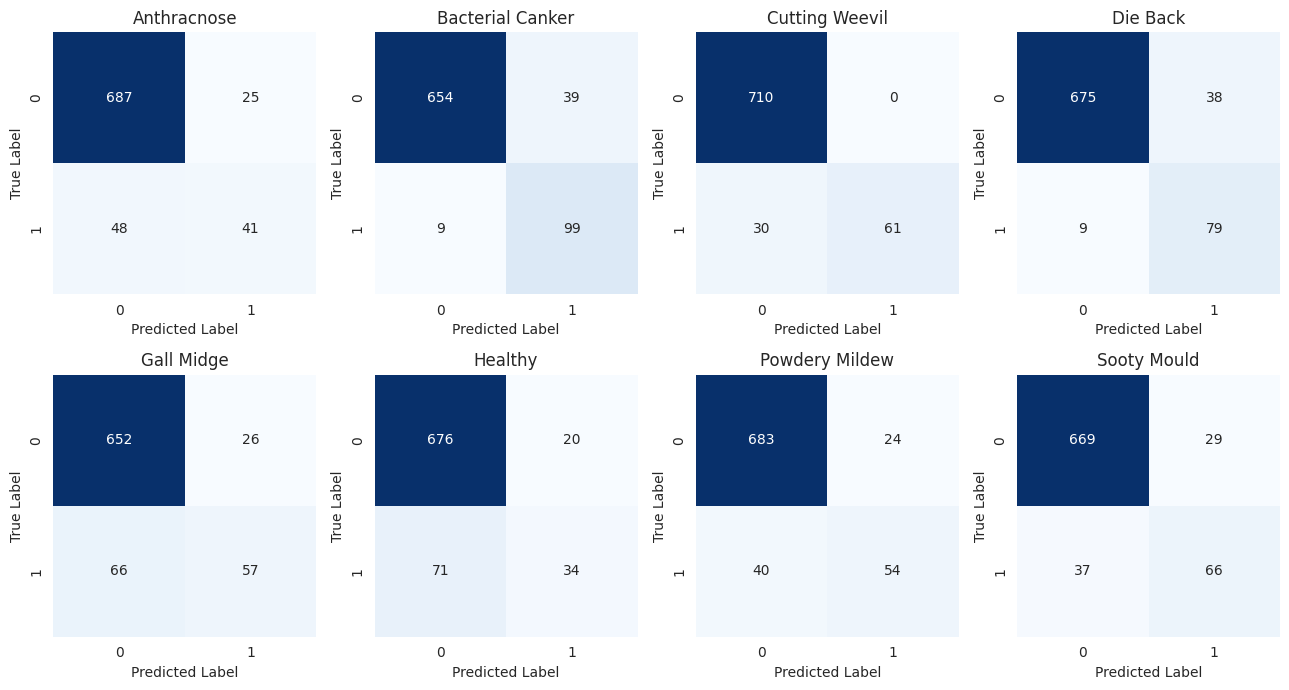

In [16]:
class_names = ["Anthracnose", "Bacterial Canker", "Cutting Weevil", "Die Back",
               "Gall Midge", "Healthy", "Powdery Mildew", "Sooty Mould"]

conf_matrices = multilabel_confusion_matrix(y_test_hot, y_pred)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(13, 7))

for i, (conf_matrix, ax) in enumerate(zip(conf_matrices, axes.flatten())):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['0', '1'], yticklabels=['0', '1'], ax=ax)
    ax.set_title(f'{class_names[i]}', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=10)
    ax.set_ylabel('True Label', fontsize=10)

plt.tight_layout()
plt.show()


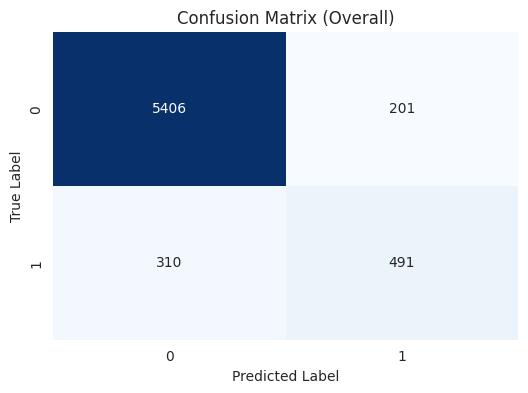

In [17]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = multilabel_confusion_matrix(y_test_hot, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix.sum(axis=0), annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix (Overall)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

model performances k=3

In [18]:
from sklearn.metrics import recall_score, precision_score, f1_score

recall = recall_score(y_test_hot, y_pred, average='macro')

precision = precision_score(y_test_hot, y_pred, average='macro')

f1 = f1_score(y_test_hot, y_pred, average='macro')

print("Recall:", recall)
print("Precision:", precision)
print("F1 score:", f1)

Recall: 0.6184833386397943
Precision: 0.7146547815960019
F1 score: 0.647864781343446


final

In [19]:
from sklearn.metrics import classification_report

class_names = ["Anthracnose", "Bacterial Canker", "Cutting Weevil", "Die Back",
               "Gall Midge", "Healthy", "Powdery Mildew", "Sooty Mould"]

print(classification_report(y_test_hot, y_pred, target_names=class_names))

                  precision    recall  f1-score   support

     Anthracnose       0.62      0.46      0.53        89
Bacterial Canker       0.72      0.92      0.80       108
  Cutting Weevil       1.00      0.67      0.80        91
        Die Back       0.68      0.90      0.77        88
      Gall Midge       0.69      0.46      0.55       123
         Healthy       0.63      0.32      0.43       105
  Powdery Mildew       0.69      0.57      0.63        94
     Sooty Mould       0.69      0.64      0.67       103

       micro avg       0.71      0.61      0.66       801
       macro avg       0.71      0.62      0.65       801
    weighted avg       0.71      0.61      0.64       801
     samples avg       0.61      0.61      0.61       801



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


knn with k=10

fit & evaluate

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np


neighbors_range = range(1, 10)
accuracies = []

for n_neighbors in neighbors_range:
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_classifier.fit(x_train_flatten, y_train_hot)

    y_pred = knn_classifier.predict(x_test_flatten)

    accuracy = accuracy_score(y_test_hot, y_pred)
    accuracies.append(accuracy)

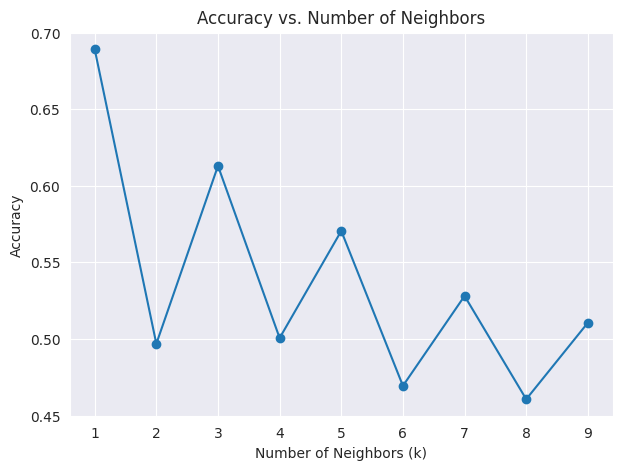



Accuracies: [0.6891385767790262, 0.4968789013732834, 0.6129837702871411, 0.5006242197253433, 0.5705368289637952, 0.46941323345817726, 0.5280898876404494, 0.4606741573033708, 0.5106117353308365]
Accuracy for K=10 : 0.5106117353308365


In [21]:
plt.figure(figsize=(7, 5))
plt.plot(neighbors_range, accuracies, marker='o')
plt.title('Accuracy vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(neighbors_range)
plt.grid(True)
plt.show()

print("\n")
print("Accuracies:", accuracies)
print(f'Accuracy for K=10 : {accuracy}')


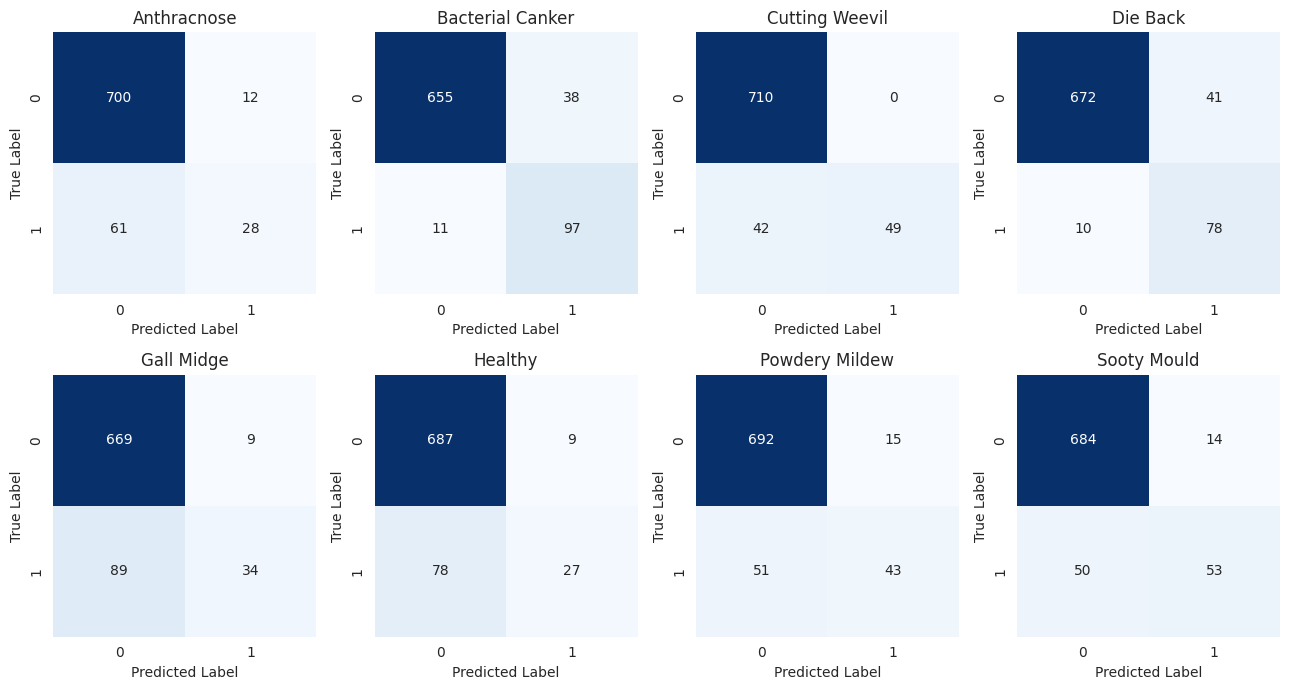

In [22]:
class_names = ["Anthracnose", "Bacterial Canker", "Cutting Weevil", "Die Back",
               "Gall Midge", "Healthy", "Powdery Mildew", "Sooty Mould"]

conf_matrices = multilabel_confusion_matrix(y_test_hot, y_pred)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(13, 7))

for i, (conf_matrix, ax) in enumerate(zip(conf_matrices, axes.flatten())):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['0', '1'], yticklabels=['0', '1'], ax=ax)
    ax.set_title(f'{class_names[i]}', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=10)
    ax.set_ylabel('True Label', fontsize=10)

plt.tight_layout()
plt.show()


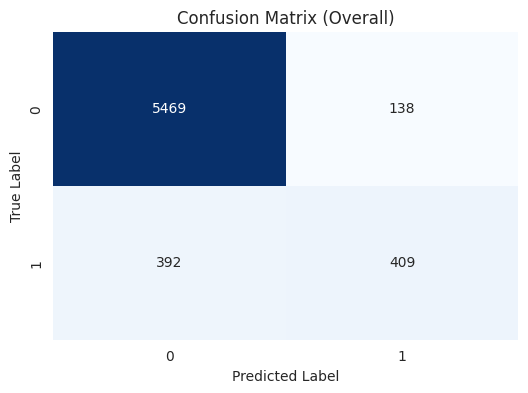

In [23]:
conf_matrix = multilabel_confusion_matrix(y_test_hot, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix.sum(axis=0), annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix (Overall)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

model performance with k=10

In [24]:
from sklearn.metrics import recall_score, precision_score, f1_score

recall = recall_score(y_test_hot, y_pred, average='macro')

precision = precision_score(y_test_hot, y_pred, average='macro')

f1 = f1_score(y_test_hot, y_pred, average='macro')

print("Recall:", recall)
print("Precision:", precision)
print("F1 score:", f1)

Recall: 0.5178944501529513
Precision: 0.7683878080344129
F1 score: 0.58350272350908


final classification report

In [25]:
from sklearn.metrics import classification_report

class_names = ["Anthracnose", "Bacterial Canker", "Cutting Weevil", "Die Back",
               "Gall Midge", "Healthy", "Powdery Mildew", "Sooty Mould"]

print(classification_report(y_test_hot, y_pred, target_names=class_names))

                  precision    recall  f1-score   support

     Anthracnose       0.70      0.31      0.43        89
Bacterial Canker       0.72      0.90      0.80       108
  Cutting Weevil       1.00      0.54      0.70        91
        Die Back       0.66      0.89      0.75        88
      Gall Midge       0.79      0.28      0.41       123
         Healthy       0.75      0.26      0.38       105
  Powdery Mildew       0.74      0.46      0.57        94
     Sooty Mould       0.79      0.51      0.62       103

       micro avg       0.75      0.51      0.61       801
       macro avg       0.77      0.52      0.58       801
    weighted avg       0.77      0.51      0.58       801
     samples avg       0.51      0.51      0.51       801



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy with different algoritm

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train_flatten, y_train_hot)

y_pred = rf_model.predict(x_test_flatten)
accuracy = accuracy_score(y_test_hot, y_pred)
print(f'Accuracy with selected features: {accuracy}')

Accuracy with selected features: 0.602996254681648
